In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Paths

In [11]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/train.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev5/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev5/val.feather')

## Load Data

In [12]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_feather(f'{TRAIN_PATH}')
test      = pd.read_feather(f'{TEST_PATH}')

CPU times: user 171 ms, sys: 44 ms, total: 215 ms
Wall time: 214 ms


In [13]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

## Feature Generation

In [14]:
%%time

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)

FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent', 'num_diff_email_types'
           ]

X_trn = traintest.iloc[:ntrain][FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click']

X_val = traintest.iloc[ntrain:][FEATURES]
y_val = traintest.iloc[ntrain:]['is_click']

print('Train nulls:\n{}'.format(X_trn.isnull().sum()))
print('\nTest nulls:\n{}'.format(X_val.isnull().sum()))

Train nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
num_emails_sent         0
num_diff_email_types    0
dtype: int64

Test nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
num_emails_sent         0
num_diff_email_types    0
dtype: int64
CPU times: user 1.55 s, sys: 360 ms, total: 1.91 s
Wall time: 1.93 s


## Train and Validate

In [15]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.63707	eval's auc: 0.563943
[40]	train's auc: 0.64605	eval's auc: 0.563262
[60]	train's auc: 0.65229	eval's auc: 0.573238
[80]	train's auc: 0.655328	eval's auc: 0.57426
[100]	train's auc: 0.657578	eval's auc: 0.577703
[120]	train's auc: 0.659235	eval's auc: 0.58314
[140]	train's auc: 0.660753	eval's auc: 0.589145
[160]	train's auc: 0.662205	eval's auc: 0.587208
[180]	train's auc: 0.663328	eval's auc: 0.587373
[200]	train's auc: 0.66416	eval's auc: 0.586448
[220]	train's auc: 0.665258	eval's auc: 0.585584
Early stopping, best iteration is:
[138]	train's auc: 0.660582	eval's auc: 0.590314


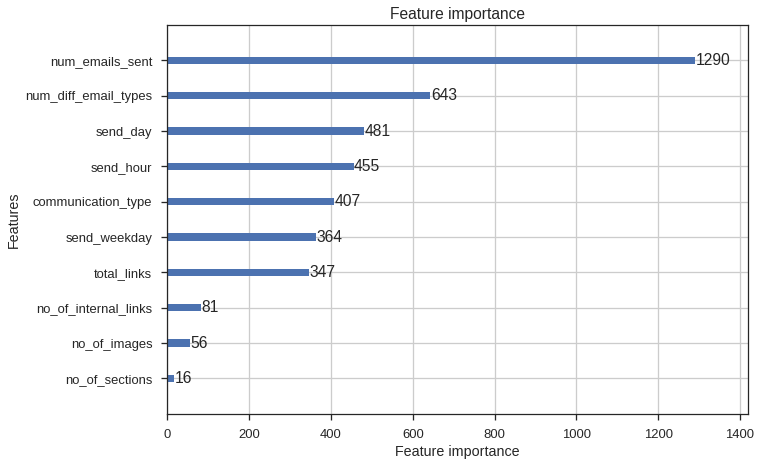

In [16]:
lgb.plot_importance(m);

## Full Training

In [8]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': (.1 / 1.1),
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
num_boost_round = int(138 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

## Submission PB Leaderboard Score: 0.558702560734757

In [10]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission10.csv', index=False)